# Notebook: Metaphor analysis

This notebook is meant to analyse the metaphors detected by the REGEX and POS approaches.

The analysis will focus on:
- frequency of the word "inflation" related to the inflation rate
- Sentiment analysis of the metaphors flagged
- Poisson regression, with the metaphors sentiment score 

In [536]:
import re
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from ecbdata import ecbdata
from sklearn.preprocessing import MinMaxScaler

from collections import Counter
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stop = stopwords.words('english')

tqdm.pandas()

#ECB Color
color = (17/255, 49/255, 147/255)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\School\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [512]:
# Target words:
words_to_match = ["inflation","deflation","inflationary","desinflationary","hyperinflation","disinflation"]

In [513]:
# Functions

# Function to count the frequency of words from the list in a sentence
def count_frequency(answer, words_to_match):
    if pd.isna(answer):
        return 0
    sentence_lower = answer.lower()
    return sum(sentence_lower.count(word) for word in words_to_match)

# Function to remove stopwords
def remove_stopwords(text):
    text = ' '.join([word for word in text.split() if word not in (stop)])
    return text

In [514]:
# Import dataset containing the interveiw data
df = pd.read_csv('Final_Working_Data_with_GPT_Output.csv')

# Convert 'date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# For computation speed, limit the data to the last 50 rows:
#df = df.tail(50)

start = df["Date"].min()
start = start.strftime('%Y-%m')
df2 = ecbdata.get_series('ICP.M.U2.N.000000.4.ANR', 
                        start=start)
df2["TIME_PERIOD"] = pd.to_datetime(df2["TIME_PERIOD"])
print("Start date is: ",start)

df.head()

Start date is:  2005-01


,Unnamed: 0,Date,Media,Member,Link,Information,Questions,Answers,Metaphors,Metaphors Sentence,...,list_regex_len,list_regex_reduced_len,text_length,pos_metaphors,pos_metaphors_len,Sentences,Frequency,Sentences_len,Sentence_GPT,Category_GPT
0,0,2005-12-23,Interview with Der Spiegel,Jean-Claude Trichet,https://www.ecb.europa.eu/press/inter/date/200...,Information not found,"SPIEGEL: Monsieur Trichet, any concrete uttera...",The publication of the translation was authori...,NaN,NaN,...,3,3,9371,[],0,['We will in the future take the decisions tha...,5,3,['we will in the future take the decisions tha...,"['machine', 'disease', 'plant']"
1,1,2005-12-19,Interview with Hospodářské Noviny,Otmar Issing,https://www.ecb.europa.eu/press/inter/date/200...,Information not found,The new EU member states want to adopt the eur...,These questions are all closely related to eac...,NaN,NaN,...,1,1,3209,[],0,['We are not confronted with deflation but wit...,1,1,['we are not confronted with deflation but wit...,['warfare']
2,2,2005-12-19,Interview with Financial Times and Financial T...,Lucas Papademos,https://www.ecb.europa.eu/press/inter/date/200...,Information not found,"Mr Papademos, you have responsibility as ECB V...",A comparison of the risks involved when short-...,NaN,NaN,...,11,10,16231,"[('low', 'inflation'), ('current', 'inflation')]",2,['If longterm interest rates remain at a low l...,18,11,['if longterm interest rates remain at a low l...,"['orientation', 'orientation', 'plant', 'orien..."
3,3,2005-12-15,Interview with Paris Match,Jean-Claude Trichet,https://www.ecb.europa.eu/press/inter/date/200...,Information not found,Paris Match. After two uneventful years at the...,The publication of the translation was authori...,NaN,NaN,...,5,4,8186,[],0,['You are exaggerating the increase in the cos...,7,5,['you are exaggerating the increase in the cos...,"['plant', 'disease', 'other', 'disease', 'mach..."
4,4,2005-12-09,Interview in Il Giornale,Lorenzo Bini Smaghi,https://www.ecb.europa.eu/press/inter/date/200...,Information not found,"However, Europe’s politicians, with few except...","By Angelo Allegri, our correspondent in Frankf...",NaN,NaN,...,7,7,6765,[],0,['The rise has helped to keep inflation expect...,7,7,['the rise has helped to keep inflation expect...,"['orientation', 'orientation', 'orientation', ..."


In [515]:
print("Shape of the dataset before dropping missing values: ", df.shape)
df.isna().sum()

Shape of the dataset before dropping missing values:  (519, 26)


Unnamed: 0                  0
Date                        0
Media                       0
Member                      0
Link                        0
Information                 0
Questions                  51
Answers                    10
Metaphors                 451
Metaphors Sentence        451
YoB                         0
Gender                      0
Country                     0
Period on the Board         0
list_regex                  0
list_regex_reduced          0
list_regex_len              0
list_regex_reduced_len      0
text_length                 0
pos_metaphors               0
pos_metaphors_len           0
Sentences                   0
Frequency                   0
Sentences_len               0
Sentence_GPT                0
Category_GPT                0
dtype: int64

In [516]:
print("Shape of the dataset after dropping missing values: ", df.shape)
df.nunique()

Shape of the dataset after dropping missing values:  (519, 26)


Unnamed: 0                519
Date                      489
Media                     259
Member                     19
Link                      519
Information               361
Questions                 465
Answers                   509
Metaphors                  59
Metaphors Sentence         59
YoB                        15
Gender                      2
Country                    10
Period on the Board        14
list_regex                407
list_regex_reduced        407
list_regex_len             38
list_regex_reduced_len     38
text_length               504
pos_metaphors             177
pos_metaphors_len          15
Sentences                 406
Frequency                  43
Sentences_len              34
Sentence_GPT              402
Category_GPT              310
dtype: int64

In [517]:
#types of data
df.dtypes

Unnamed: 0                         int64
Date                      datetime64[ns]
Media                             object
Member                            object
Link                              object
Information                       object
Questions                         object
Answers                           object
Metaphors                         object
Metaphors Sentence                object
YoB                                int64
Gender                            object
Country                           object
Period on the Board               object
list_regex                        object
list_regex_reduced                object
list_regex_len                     int64
list_regex_reduced_len             int64
text_length                        int64
pos_metaphors                     object
pos_metaphors_len                  int64
Sentences                         object
Frequency                          int64
Sentences_len                      int64
Sentence_GPT    

In [518]:
"""
# Run only once: The data will be saved in the right format afterwards.

# lambda function to convert string representations of lists into actual lists
parse_list = lambda x: ast.literal_eval(x) if isinstance(x, str) and x != '[\'None\']' else []
df.loc[:, 'Metaphors'] = df['Metaphors'].apply(parse_list)

# lambda function to count the elements in each list
df.loc[:, 'Metaphors_len'] = df['Metaphors'].apply(len)"""

"\n# Run only once: The data will be saved in the right format afterwards.\n\n# lambda function to convert string representations of lists into actual lists\nparse_list = lambda x: ast.literal_eval(x) if isinstance(x, str) and x != '['None']' else []\ndf.loc[:, 'Metaphors'] = df['Metaphors'].apply(parse_list)\n\n# lambda function to count the elements in each list\ndf.loc[:, 'Metaphors_len'] = df['Metaphors'].apply(len)"

In [519]:
# function to convert string representations of lists into actual lists
parse_list = lambda x: ast.literal_eval(x) if x != '[]' else []
df.loc[:, 'Sentence_GPT'] = df['Sentence_GPT'].apply(parse_list)

df['GPT_Lenght'] = df['Sentence_GPT'].apply(len)

# EDA on the (human) labeled data

In [520]:
# Dataframe with the labeled Metaphors
df_labels = df[df['Metaphors'].notnull()].copy()
print("Shape of the dataset with labeled Metaphors: ", df_labels.shape)

Shape of the dataset with labeled Metaphors:  (68, 27)


In [521]:
df_labels.isna().sum()

Unnamed: 0                0
Date                      0
Media                     0
Member                    0
Link                      0
Information               0
Questions                 6
Answers                   0
Metaphors                 0
Metaphors Sentence        0
YoB                       0
Gender                    0
Country                   0
Period on the Board       0
list_regex                0
list_regex_reduced        0
list_regex_len            0
list_regex_reduced_len    0
text_length               0
pos_metaphors             0
pos_metaphors_len         0
Sentences                 0
Frequency                 0
Sentences_len             0
Sentence_GPT              0
Category_GPT              0
GPT_Lenght                0
dtype: int64

In [522]:
# lambda function to convert string representations of lists into actual lists
parse_list = lambda x: ast.literal_eval(x) if x != '[\'None\']' else []
df_labels.loc[:, 'Metaphors'] = df_labels['Metaphors'].apply(parse_list)

# lambda function to count the elements in each list
df_labels.loc[:, 'Metaphors_len'] = df_labels['Metaphors'].apply(len)

In [523]:
# Count the frequency of words from the list words_to_match
df_labels["Frequency"] = df_labels["Answers"].apply(count_frequency, words_to_match=words_to_match)

In [524]:
df_labels.head()

,Unnamed: 0,Date,Media,Member,Link,Information,Questions,Answers,Metaphors,Metaphors Sentence,...,text_length,pos_metaphors,pos_metaphors_len,Sentences,Frequency,Sentences_len,Sentence_GPT,Category_GPT,GPT_Lenght,Metaphors_len
47,47,2009-09-12,"Interview with the ""Junge Zeitung“ of the Fran...",Jean-Claude Trichet,https://www.ecb.europa.eu/press/inter/date/200...,Information not found,NaN,"Mr. President, as „Mr. Euro“: How many Euros d...","[fear deflation, inflation below, preserved th...","['Or does the ECB fear deflation', 'Our defini...",...,11198,[],0,"['At the moment there is no inflation.', 'Can ...",7,5,[since the inception of the single currency we...,"['warfare', 'sports']",2,5
65,65,2010-04-24,Interview with Expresso,Jean-Claude Trichet,https://www.ecb.europa.eu/press/inter/date/201...,Information not found,Are we really leaving the crisis behind or are...,As regards the conjuncture in the real economy...,[],['None'],...,12101,[],0,[],0,0,[],[],0,0
73,73,2011-10-18,Interview with Frankfurter Allgemeine Zeitung,Jean-Claude Trichet,https://www.ecb.europa.eu/press/inter/date/201...,Information not found,"Mr Trichet, do you believe in destiny?[end_que...",I have used that term on a few occasions – inc...,"[experience of hyperinflationr, experienced hy...","['As regards inflation, I understand the deep-...",...,12782,"[('annual', 'inflation')]",1,['Average annual inflation has at 2.0 over the...,9,6,[as regards inflation i understand the deepsea...,"['disease', 'orientation']",2,4
79,79,2011-09-20,Interview with Expansión,Jean-Claude Trichet,https://www.ecb.europa.eu/press/inter/date/201...,Information not found,1. At the last meeting you said that the risks...,At the last meeting of the Governing Council w...,"[upside risks to inflation, materialisation of...","['On the other hand, in July there were upside...",...,7295,[],0,['On the other hand in July there were upside ...,3,2,[on the other hand in july there were upside r...,"['orientation', 'warfare']",2,3
85,85,2011-06-16,Interview with The Times,Jean-Claude Trichet,https://www.ecb.europa.eu/press/inter/date/201...,Information not found,The Times: There are two camps: one that empha...,Jean-Claude Trichet: All advanced economies ar...,"[anchor very solidly inflation, materialisatio...",['What I would say is that in our case it is v...,...,10455,"[('annual', 'inflation')]",1,['Annual average inflation over the past 12 ye...,12,6,[what i would say is that in our case it is ve...,"['orientation', 'orientation', 'sports', 'spor...",5,5


c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

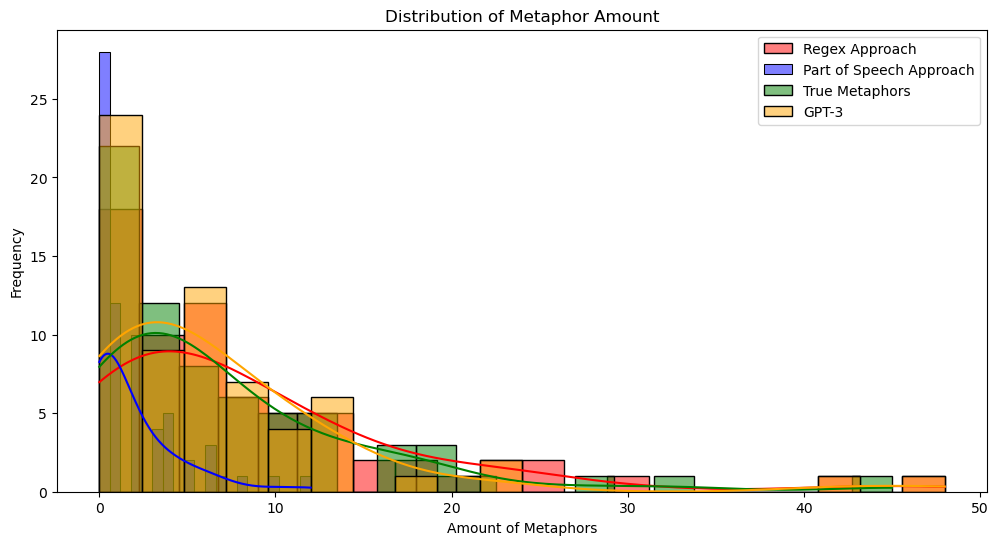

In [525]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df_labels, x='list_regex_reduced_len', bins=20, kde=True, color='red', label='Regex Approach')
sns.histplot(data=df_labels, x='pos_metaphors_len', bins=20, kde=True, color='blue', label='Part of Speech Approach')
sns.histplot(data=df_labels, x='Metaphors_len', bins=20, kde=True, color='green', label='True Metaphors')
sns.histplot(data=df_labels, x='GPT_Lenght', bins=20, kde=True, color='orange', label='GPT-3')
plt.title('Distribution of Metaphor Amount')
plt.xlabel('Amount of Metaphors')
plt.ylabel('Frequency')
plt.legend()
plt.show()

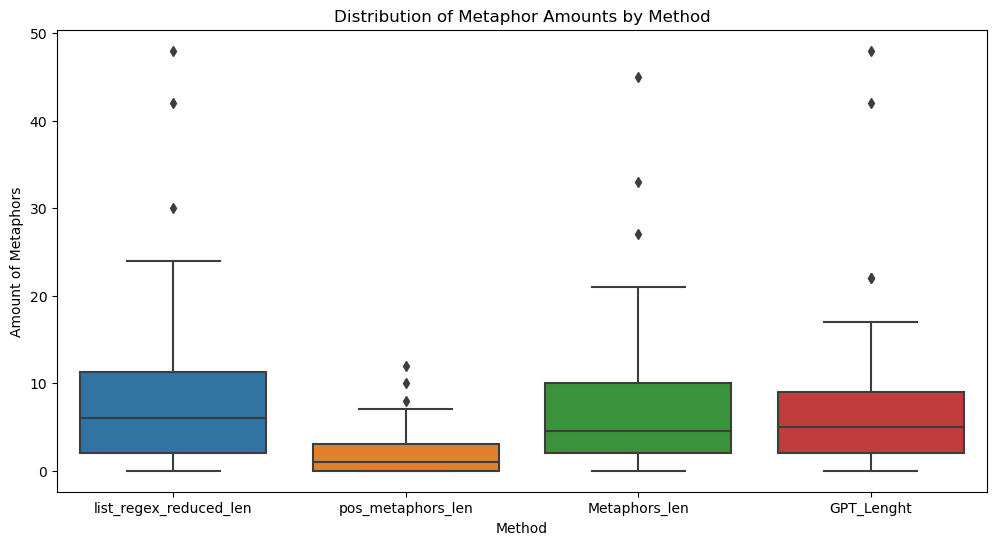

In [526]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_labels[['list_regex_reduced_len', 'pos_metaphors_len', 'Metaphors_len', 'GPT_Lenght']])
plt.title('Distribution of Metaphor Amounts by Method')
plt.xlabel('Method')
plt.ylabel('Amount of Metaphors')
plt.show()

In [527]:
# Order the "Metaphor_len" and print top 5
df_labels.sort_values(by='Metaphors_len', ascending=False).head()

,Unnamed: 0,Date,Media,Member,Link,Information,Questions,Answers,Metaphors,Metaphors Sentence,...,text_length,pos_metaphors,pos_metaphors_len,Sentences,Frequency,Sentences_len,Sentence_GPT,Category_GPT,GPT_Lenght,Metaphors_len
509,509,2023-01-17,Interview with Financial Times,Philip R. Lane,https://www.ecb.europa.eu/press/inter/date/202...,"Interview with Philip R. Lane, Member of the E...","From your perspective, how much do you see the...",17 January 2023[end_answer] The way to think a...,"[inflationary pressure, inflationary environme...",['For me the way to differentiate these narrat...,...,25435,"[('inflation', 'come'), ('inflation', 'fight')...",12,['Theres a large global component to inflation...,68,48,[for me the way to differentiate these narrati...,"['liquids', 'other', 'liquids', 'liquids', 'li...",48,45
483,483,2023-09-05,Interview with The Currency,Philip R. Lane,https://www.ecb.europa.eu/press/inter/date/202...,"Interview with Philip R. Lane, Member of the E...",Let’s dive straight in and talk about the broa...,5 September 2023[end_answer] We’re speaking to...,"[inflation came down, inflation come down, inf...",['So goods inflation and services inflation ca...,...,28488,"[('inflation', 'come'), ('inflation', 'come'),...",10,['Of course in any given month the change is r...,56,42,[of course in any given month the change is re...,"['liquid', 'orientation', 'orientation', 'liqu...",42,33
439,439,2022-11-21,Interview with Market News,Philip R. Lane,https://www.ecb.europa.eu/press/inter/date/202...,"Interview with Philip R. Lane, Member of the E...",What do you expect December’s Eurosystem growt...,21 November 2022[end_answer] The staff project...,"[inflation is higher, starting point for infla...","['Number one, inflation is higher now than was...",...,18889,"[('inflation', 'come'), ('inflation', 'go'), (...",5,['Number one inflation is higher now than was ...,33,30,[even if this does not have an immediate effec...,"['other', 'other', 'other', 'other', 'orientat...",12,27
316,316,2020-12-02,Transcript of the fireside chat at Reuters Glo...,Philip R. Lane,https://www.ecb.europa.eu/press/inter/date/202...,"Interview with Philip R. Lane, Member of the E...",The pandemic has of course dominated your year...,"2 December 2020[end_answer] As you indicate, w...","[shock to inflation, convergence of inflation,...","['So, if we can keep financing conditions wher...",...,19777,"[('inflation', 'get'), ('low', 'inflation')]",2,['So if we can keep financing conditions where...,23,20,[its very difficult to live with a reversal of...,"['other', 'other', 'orientation', 'other', 'ot...",7,21
172,172,2015-03-25,Interview with Il Sole 24 Ore,Peter Praet,https://www.ecb.europa.eu/press/inter/date/201...,Information not found,"In the ECB latest projections, as in those of ...","After two recessions, the first in 2009 and an...","[inflation was remaining weak, inflation expec...","['Then, in November, we saw that inflation was...",...,12887,"[('annual', 'inflation'), ('core', 'inflation'...",3,['Then in November we saw that inflation was r...,24,17,[then in november we saw that inflation was re...,"['disease', 'warfare', 'other', 'disease', 'or...",17,18


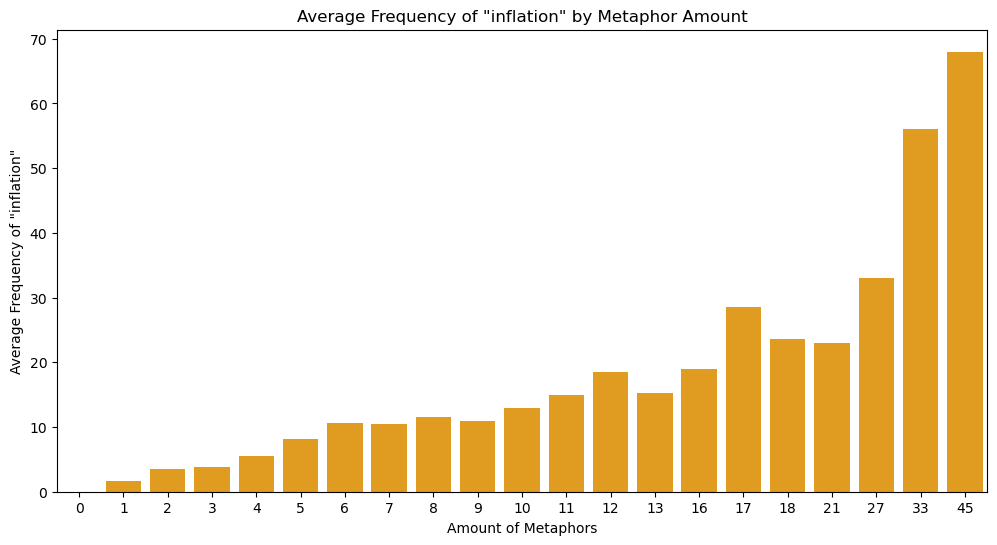

In [528]:
avg_freq_by_length = df_labels.groupby('Metaphors_len')['Frequency'].mean()
plt.figure(figsize=(12, 6))
sns.barplot(x=avg_freq_by_length.index, y=avg_freq_by_length.values, color='orange')
plt.title('Average Frequency of "inflation" by Metaphor Amount')
plt.xlabel('Amount of Metaphors')
plt.ylabel('Average Frequency of "inflation"')
plt.show()

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


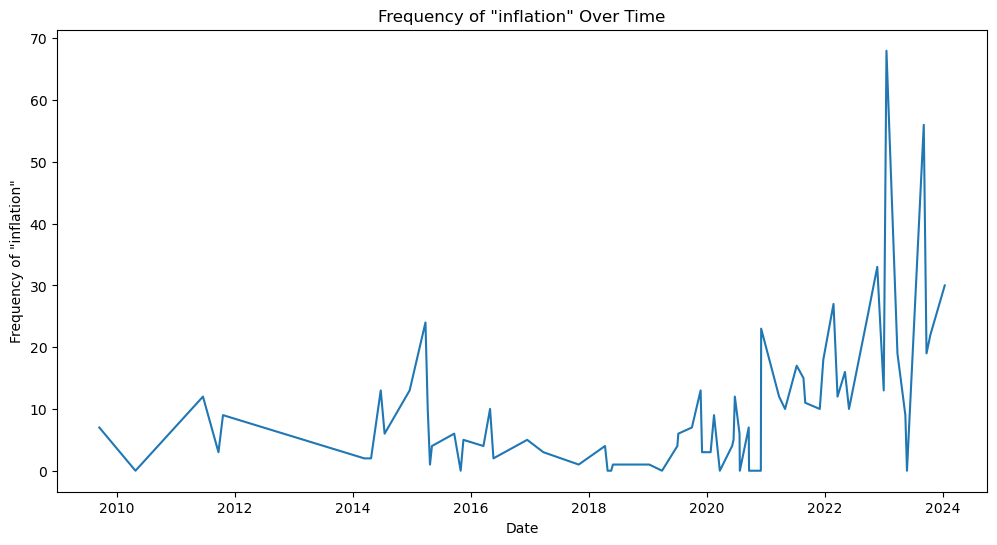

In [529]:

# For the entire dataset
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_labels, x='Date', y='Frequency')
plt.title('Frequency of "inflation" Over Time')
plt.xlabel('Date')
plt.ylabel('Frequency of "inflation"')
plt.show()

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


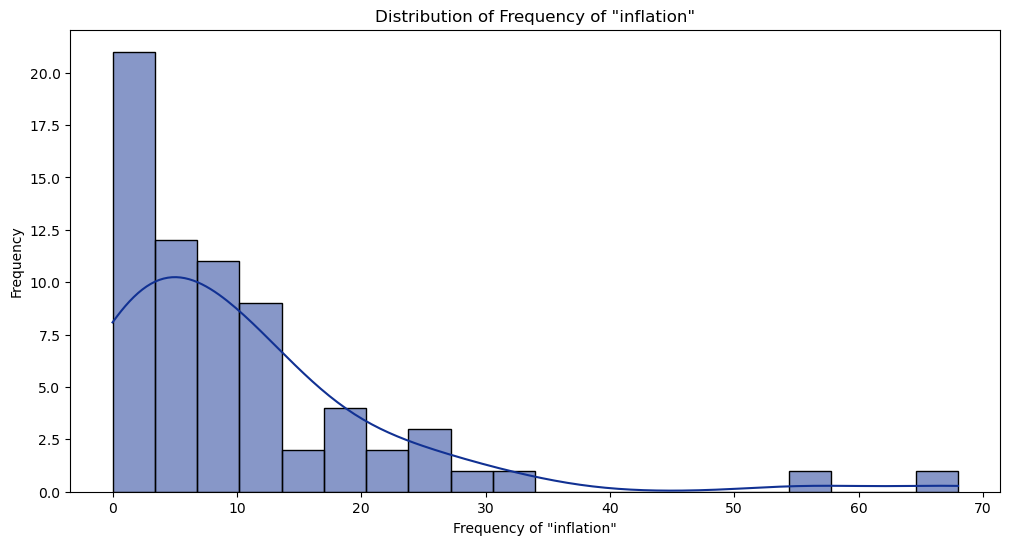

In [530]:
# Plot the Frequency 
plt.figure(figsize=(12, 6))
sns.histplot(data=df_labels, x='Frequency', bins=20, kde=True, color=color)
plt.title('Distribution of Frequency of "inflation"')
plt.xlabel('Frequency of "inflation"')
plt.ylabel('Frequency')
plt.show()


## Metrics: basic appraoches vs human label

COMPARES ONLY THE AMOUNT OF METAPHORS DETECTED? NOT IF THEY ARE THE SAME

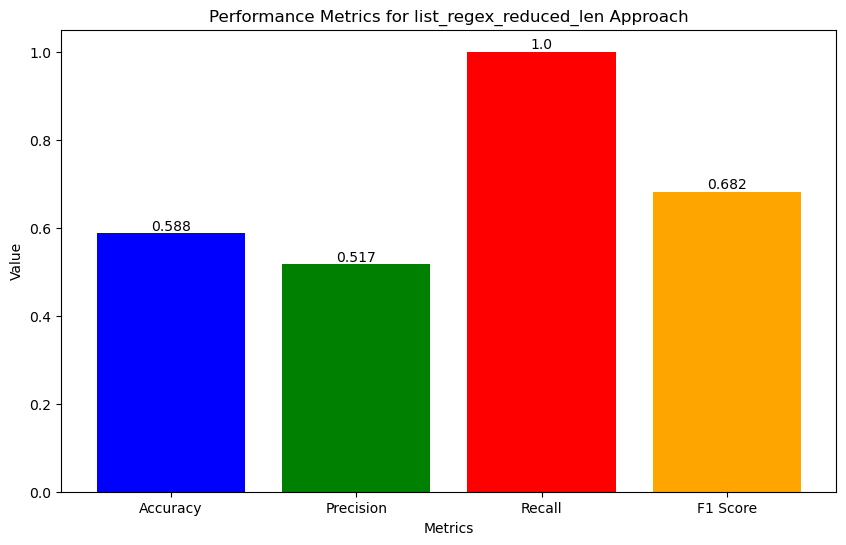

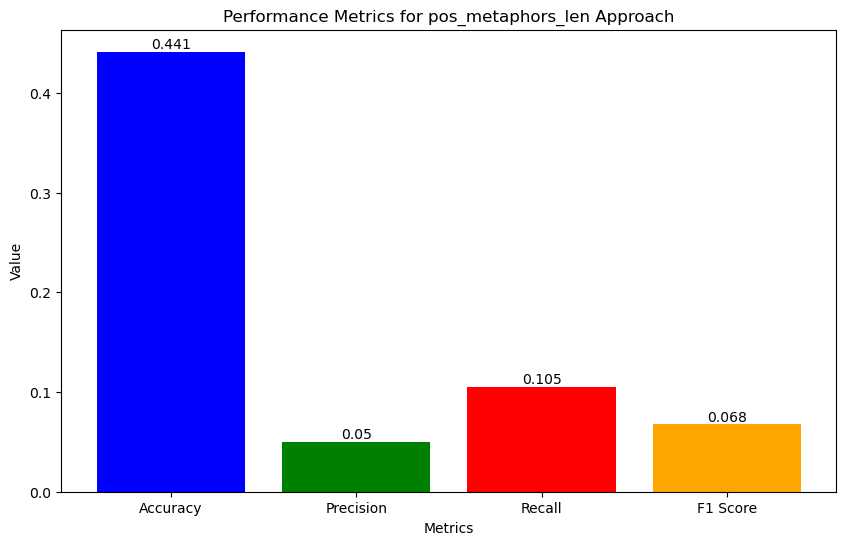

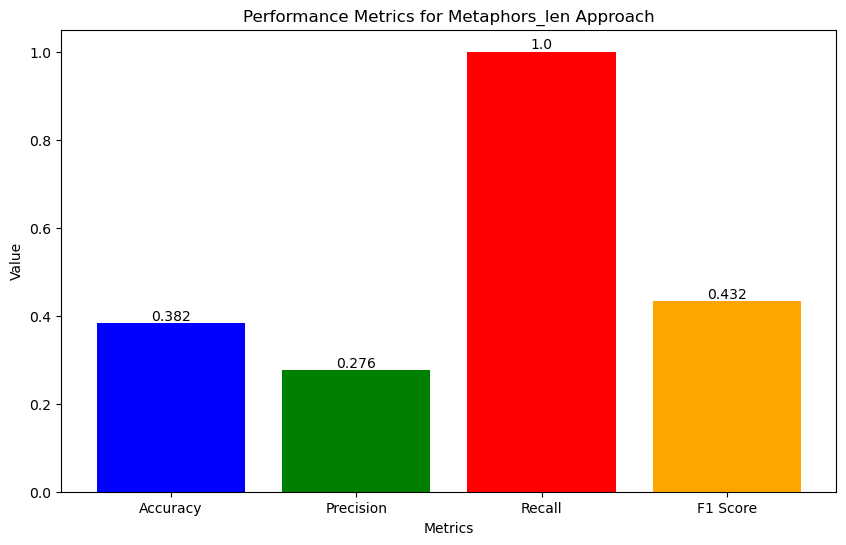

In [531]:
def evaluate_approach(df, approach):
    # Compute metrics for the given approach
    true_positives = ((df[approach] != 0) & (df['GPT_Lenght'] == df[approach])).sum()
    false_positives = ((df[approach] != 0) & (df['GPT_Lenght'] != df[approach])).sum()
    false_negatives = ((df[approach] == 0) & (df['GPT_Lenght'] != 0)).sum()

    # Calculate metrics
    accuracy = (true_positives + (df[approach] == 0).sum()) / len(df)
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) != 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) != 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

    # Plot results
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    values = [accuracy, precision, recall, f1_score]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(metrics, values, color=['blue', 'green', 'red', 'orange'])
    plt.xlabel('Metrics')
    plt.ylabel('Value')
    plt.title(f'Performance Metrics for {approach} Approach')

    # Annotate bars with values
    for bar, value in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width() / 2, value, round(value, 3), 
                 ha='center', va='bottom')

    plt.show()

evaluate_approach(df_labels, 'list_regex_reduced_len')
evaluate_approach(df_labels, 'pos_metaphors_len')
evaluate_approach(df_labels, 'Metaphors_len')

# EDA on the (GPT) labeled data

In [532]:
# Add Ratio of Metaphors to the dataframe, Frequency / text length
df['Ratio'] = df['Frequency'] / df['text_length']
df.head()

,Unnamed: 0,Date,Media,Member,Link,Information,Questions,Answers,Metaphors,Metaphors Sentence,...,text_length,pos_metaphors,pos_metaphors_len,Sentences,Frequency,Sentences_len,Sentence_GPT,Category_GPT,GPT_Lenght,Ratio
0,0,2005-12-23,Interview with Der Spiegel,Jean-Claude Trichet,https://www.ecb.europa.eu/press/inter/date/200...,Information not found,"SPIEGEL: Monsieur Trichet, any concrete uttera...",The publication of the translation was authori...,NaN,NaN,...,9371,[],0,['We will in the future take the decisions tha...,5,3,[we will in the future take the decisions that...,"['machine', 'disease', 'plant']",3,0.000534
1,1,2005-12-19,Interview with Hospodářské Noviny,Otmar Issing,https://www.ecb.europa.eu/press/inter/date/200...,Information not found,The new EU member states want to adopt the eur...,These questions are all closely related to eac...,NaN,NaN,...,3209,[],0,['We are not confronted with deflation but wit...,1,1,[we are not confronted with deflation but with...,['warfare'],1,0.000312
2,2,2005-12-19,Interview with Financial Times and Financial T...,Lucas Papademos,https://www.ecb.europa.eu/press/inter/date/200...,Information not found,"Mr Papademos, you have responsibility as ECB V...",A comparison of the risks involved when short-...,NaN,NaN,...,16231,"[('low', 'inflation'), ('current', 'inflation')]",2,['If longterm interest rates remain at a low l...,18,11,[if longterm interest rates remain at a low le...,"['orientation', 'orientation', 'plant', 'orien...",11,0.001109
3,3,2005-12-15,Interview with Paris Match,Jean-Claude Trichet,https://www.ecb.europa.eu/press/inter/date/200...,Information not found,Paris Match. After two uneventful years at the...,The publication of the translation was authori...,NaN,NaN,...,8186,[],0,['You are exaggerating the increase in the cos...,7,5,[you are exaggerating the increase in the cost...,"['plant', 'disease', 'other', 'disease', 'mach...",5,0.000855
4,4,2005-12-09,Interview in Il Giornale,Lorenzo Bini Smaghi,https://www.ecb.europa.eu/press/inter/date/200...,Information not found,"However, Europe’s politicians, with few except...","By Angelo Allegri, our correspondent in Frankf...",NaN,NaN,...,6765,[],0,['The rise has helped to keep inflation expect...,7,7,[the rise has helped to keep inflation expecta...,"['orientation', 'orientation', 'orientation', ...",7,0.001035


c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


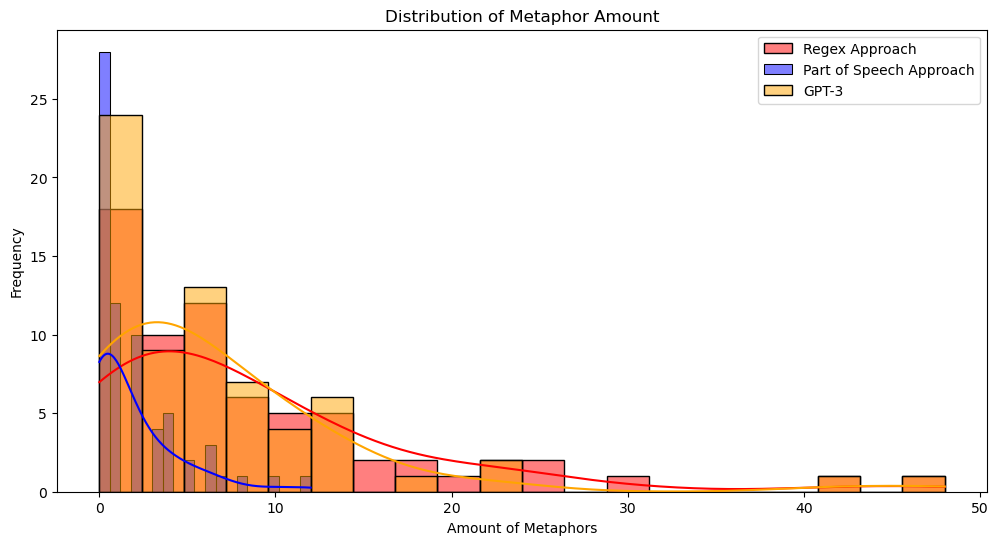

In [533]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df_labels, x='list_regex_reduced_len', bins=20, kde=True, color='red', label='Regex Approach')
sns.histplot(data=df_labels, x='pos_metaphors_len', bins=20, kde=True, color='blue', label='Part of Speech Approach')
sns.histplot(data=df_labels, x='GPT_Lenght', bins=20, kde=True, color='orange', label='GPT-3')
plt.title('Distribution of Metaphor Amount')
plt.xlabel('Amount of Metaphors')
plt.ylabel('Frequency')
plt.legend()
plt.show()

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

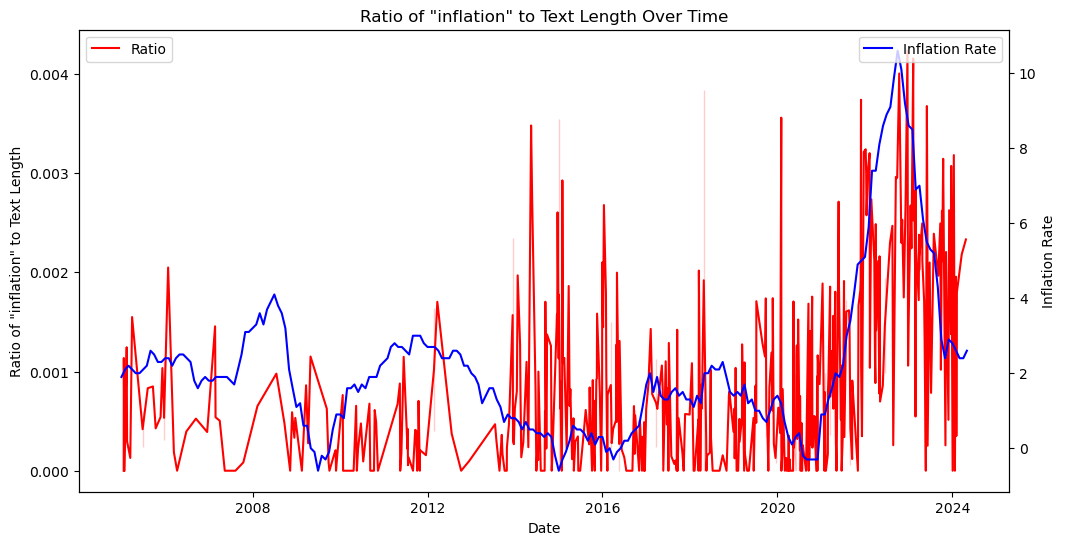

In [535]:
# Plot the Ratio over time with the Inflation Rate
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Date', y='Ratio', color='red', label='Ratio')
plt.title('Ratio of "inflation" to Text Length Over Time')
plt.xlabel('Date')
plt.ylabel('Ratio of "inflation" to Text Length')
plt.legend(loc='upper left')

# Plot the Inflation Rate
plt.twinx()
sns.lineplot(data=df2, x='TIME_PERIOD', y='OBS_VALUE', color='blue', label='Inflation Rate')
plt.ylabel('Inflation Rate')
plt.legend(loc='upper right')

plt.show()

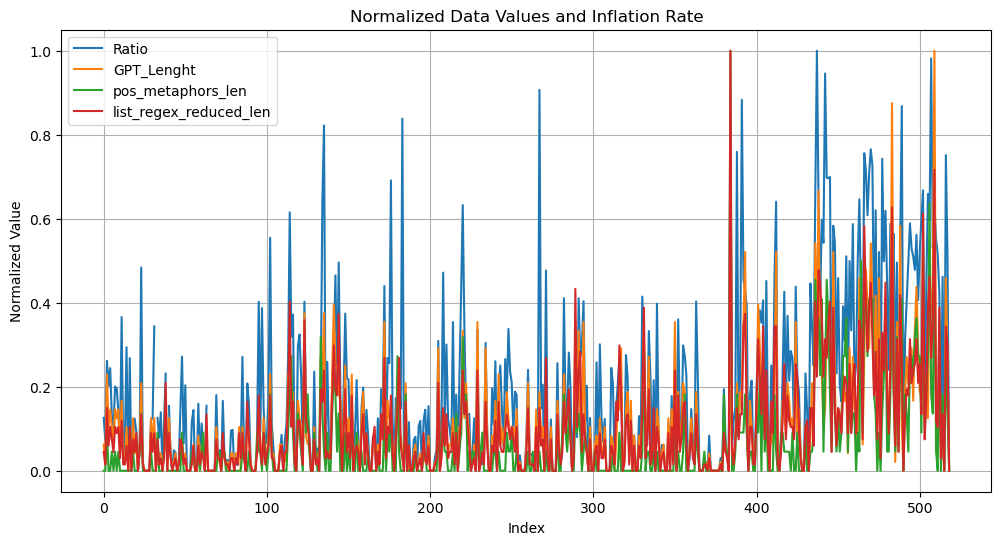

In [547]:
# Create a copy of the specified columns
columns_to_normalize = ['Ratio', 'GPT_Lenght', 'pos_metaphors_len', 'list_regex_reduced_len']
df_copy = df[columns_to_normalize].copy()

# Normalize the values in these columns
scaler = MinMaxScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(df_copy), columns=df_copy.columns)

# Plot normalized values against each other
plt.figure(figsize=(12, 6))

for column in df_normalized.columns:
    plt.plot(df_normalized.index, df_normalized[column], label=column)

# Customize the plot
plt.xlabel('Index')
plt.ylabel('Normalized Value')
plt.title('Normalized Data Values')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

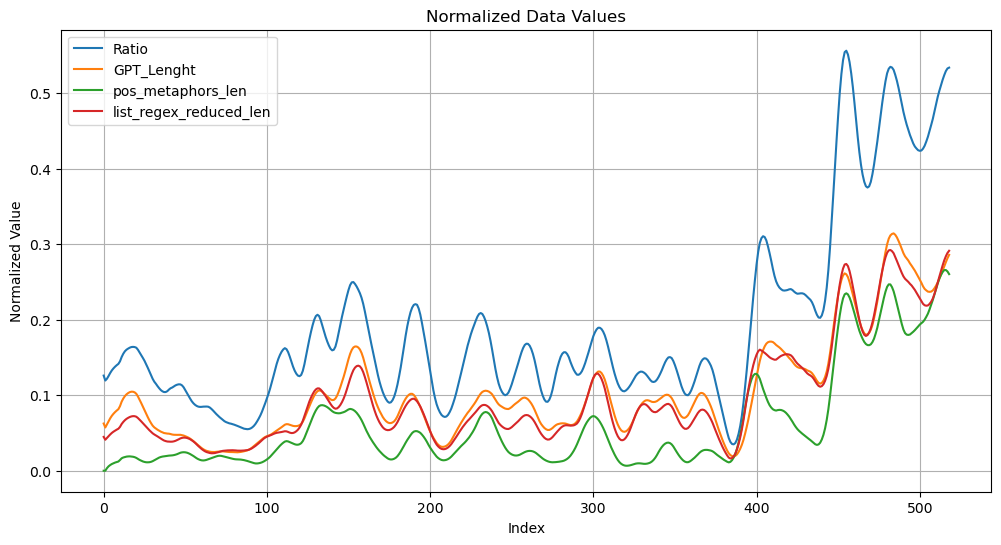

In [550]:
# Smooth plot:
def moving_average(data, window_size):
    return data.rolling(window=window_size, min_periods=1).mean()

plt.figure(figsize=(12, 6))
# Apply moving average to smooth the lines
window_size = 10
for column in columns_to_normalize:
    df_normalized[column] = moving_average(df_normalized[column], window_size)

for column in df_normalized.columns:
    plt.plot(df_normalized.index, df_normalized[column], label=column)

# Customize the plot
plt.xlabel('Index')
plt.ylabel('Normalized Value')
plt.title('Normalized Data Values')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

In [ ]:
# TODO: Total number of metaphors labeled, total number of sentences, total number of Frequency
# TODO: Check Metaphors and Metaphors Sentence have the same length